# SM108 silencing RL Modelling

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats

from flyjax.experiment.get import fetch_behavioral_data, get_experiments
from flyjax.utils.plotting import plot_single_experiment_data

import seaborn as sns
sns.set(style='ticks')
sns.set_palette('colorblind')
plt.rcParams['font.sans-serif'] = 'Arial'

def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

expt_data_folder = '../../../data/SMP108-kir/dmVS_12-08-2024_expt/'
ctrl_data_folder = '../../../data/SMP108-kir/dmVS_12-08-2024_ctrl/'
processed_folder = 'processed_data' # folder containing the processed data
minimal_trials = 180 # minimal number of trials to consider a fly to be included in the analysis

expt_choices, expt_rewards, expt_metadata = fetch_behavioral_data(expt_data_folder, minimal_trials, remove_control=True)
n_experiments = len(expt_metadata)

ctrl_choices, ctrl_rewards, ctrl_metadata = fetch_behavioral_data(ctrl_data_folder, minimal_trials, remove_control=False)
n_controls = len(ctrl_metadata)

# set the seed for reproducibility
np.random.seed(0)

In [2]:
print(f'Number of experiments: {n_experiments}')
print(f'Number of controls: {n_controls}')

Number of experiments: 247
Number of controls: 299


## Fitting the best joint model (DFQ with Dynamic Exploration) to the experimental and control data

In [3]:
# fitting a joint model to the data
from flyjax.fitting.cv import parallel_k_fold_cross_validation_train_joint
from flyjax.agent.rl.zoo import dfq_agent_with_dynamic_exploration
from flyjax.fitting.samplers import base_randn_sampler
from functools import partial

In [4]:
experiments = [(expt_choices[i], expt_rewards[i]) for i in range(n_experiments)]
controls = [(ctrl_choices[i], ctrl_rewards[i]) for i in range(n_controls)]

In [5]:
init_theta_sampler = partial(base_randn_sampler, mean=0.0, std=1.0, n_params=7)
init_delta_sampler = partial(base_randn_sampler, mean=0.0, std=0.1, n_params=7)

total_pred_ll, per_experiment_ll, params = parallel_k_fold_cross_validation_train_joint(
    experiments_control=controls,
    experiments_treatment=experiments,
    k=5,
    init_theta_sampler=init_theta_sampler,
    init_delta_sampler=init_delta_sampler,
    agent=dfq_agent_with_dynamic_exploration,
    learning_rate=5e-2,
    num_steps=10000,
    n_restarts=10,
    min_num_converged=3,
    early_stopping={"min_delta": 1e-4}
)

# make a nested dictionary with the results
results = {
    'total_log_likelihood': total_pred_ll,
    'subject_log_likelihood': per_experiment_ll,
    'fold_params': params
}
# save the results as a pickle file
results_file = os.path.join(processed_folder, 'dfq_dynamic_exploration_results.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(results, f)


--- Joint Restart 1/10 ---

--- Joint Restart 1/10 ---

--- Joint Restart 1/10 ---

--- Joint Restart 1/10 ---

--- Joint Restart 1/10 ---


TypeError: add got incompatible shapes for broadcasting: (4,), (10,).

In [ ]:
# load the results
results_file = os.path.join(processed_folder, 'dfq_dynamic_exploration_results.pkl')
with open(results_file, 'rb') as f:
    results = pickle.load(f)
total_pred_ll = results['total_log_likelihood']
per_experiment_ll = results['subject_log_likelihood']
params = results['fold_params']
params = np.array([params[i] for i in range(5)])
params = np.cumsum(params, axis=1)
# apply sigmoid on the first two parameters
params[:, :, :2] = 1 / (1 + np.exp(-params[:, :, :2]))

In [28]:
params

array([[[-2.0493348 , -2.2053452 ,  5.9874663 ,  1.419741  ],
        [-1.1448095 , -0.9947907 ,  2.9072204 ,  1.3756939 ]],

       [[-1.6875918 , -1.7867942 ,  3.1903224 ,  0.8651489 ],
        [-0.88740057, -1.3865542 ,  2.2347164 ,  1.6539698 ]],

       [[-0.9199833 , -1.1498469 ,  2.4107876 ,  1.3235854 ],
        [-1.1815134 , -1.0493734 ,  1.6400489 ,  1.4423677 ]],

       [[-1.8422422 , -2.0634913 ,  3.3908975 ,  1.3369058 ],
        [-0.5774637 , -0.48767522,  1.9994127 ,  1.6822902 ]],

       [[-1.8605747 , -1.8215288 ,  3.486065  ,  0.7307393 ],
        [-0.92881083, -1.4261916 ,  2.2566996 ,  1.8239784 ]]],
      dtype=float32)

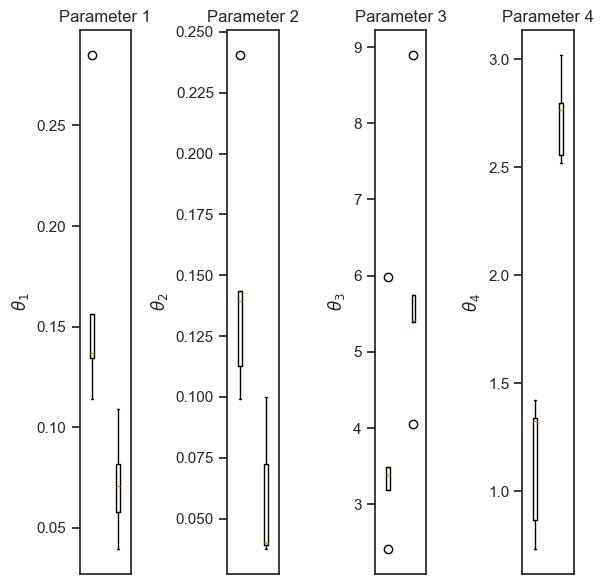

In [23]:
# plot the parameters
fig, axes = plt.subplots(1, 4, figsize=(6, 6), sharex=True)
for i in range(4):
    axes[i].boxplot(params[:, : ,i])
    axes[i].set_ylabel(f'$\\theta_{i+1}$')
    axes[i].set_xticks([])
    axes[i].set_title(f'Parameter {i+1}')
plt.tight_layout()
plt.show()

These are nested models, so we can compare them using a likelihood ratio test. We will additionally compare the models using the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC) and also percentage of variance explained by the models.

In [ ]:
# since the model to evaluate is DFQ, we will first use the log likelihood ratio test to compare it to the other models
from flyjax.fitting.model_comparison import likelihood_ratio_test, aic, bic

# compute the log likelihood ratio test of DFQ every other model
dfq_vs_dq = likelihood_ratio_test(
            ll_full=dfq_results['total_log_likelihood'],
            ll_restricted=dq_results['total_log_likelihood'],
            num_params_full=4,
            num_params_restricted=3
            )
dfq_vs_fq = likelihood_ratio_test(
            ll_full=dfq_results['total_log_likelihood'],
            ll_restricted=fq_results['total_log_likelihood'],
            num_params_full=4,
            num_params_restricted=3
            )
dfq_vs_q = likelihood_ratio_test(
            ll_full=dfq_results['total_log_likelihood'],
            ll_restricted=q_results['total_log_likelihood'],
            num_params_full=4,
            num_params_restricted=2
            )
dfq_vs_random = likelihood_ratio_test(
            ll_full=dfq_results['total_log_likelihood'],
            ll_restricted=random_results['total_log_likelihood'],
            num_params_full=4,
            num_params_restricted=0
            )
print(f"DFQ vs DQ: {dfq_vs_dq:.2f}; DFQ vs FQ: {dfq_vs_fq:.2f}; DFQ vs Q: {dfq_vs_q:.2f}; DFQ vs Random: {dfq_vs_random:.2f}")

The fact that the likelihood ratio test is significant for the nested models suggests that every term in the DFQ model is important for explaining the data. Lets plot the results and compare the models.

In [ ]:
# create a subject-level dataframe
dfq_subjects = pd.DataFrame(dfq_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
dfq_subjects['model'] = 'DFQ'
dq_subjects = pd.DataFrame(dq_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
dq_subjects['model'] = 'DQ'
fq_subjects = pd.DataFrame(fq_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
fq_subjects['model'] = 'FQ'
q_subjects = pd.DataFrame(q_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
q_subjects['model'] = 'Q'
random_subjects = pd.DataFrame(random_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
random_subjects['model'] = 'Random'
# concatenate the dataframes
subjects = pd.concat([dfq_subjects, dq_subjects, fq_subjects, q_subjects, random_subjects])

# sort by model and subject
subjects = subjects.sort_values(by=['model', 'subject']).reset_index(drop=True)

# get index for DFQ model
dfq_idx = subjects[subjects['subject']==0].reset_index(drop=True)
dfq_idx = dfq_idx[dfq_idx['model']=='DFQ'].index[0]
print(dfq_idx)

# for each subject, get the number of trials
subjects['n_trials'] = subjects['subject'].apply(lambda x: len(experiments[x][0]))
# get normalized likelihoods exp(log likelihood/n_trials)
subjects['normalized_likelihood'] = np.exp(subjects['log_likelihood']/subjects['n_trials'])

# from each subject, divide the log likelihood of the DFQ model
subjects['normalized_likelihood_change'] = subjects.groupby('subject')['normalized_likelihood'].transform(lambda x: x/x.iloc[0])
# convert the log likelihoods to a percentage scale
subjects['normalized_likelihood_change'] = (subjects['normalized_likelihood_change']-1)*100


# plot the log likelihoods of the different models with paired scatter plots
plt.figure(figsize=(2, 4))
# drop DFQ vs DFQ
subjects_change = subjects[subjects['model'] != 'DFQ']
order = subjects_change.groupby('model')['normalized_likelihood_change'].median().sort_values(ascending=False).index.tolist()

# change the names of the models
subjects_change.loc[:, 'model'] = subjects_change['model'].replace({
    'DQ': 'No Forgetting',
    'FQ': 'No Choice Bias',
    'Q': 'No Forgetting\nor Choice Bias',
    'Random': 'No Learning'
})
order_changed = ['No Learning' if x=='Random' else x for x in order]
order_changed = ['No Forgetting\nor Choice Bias' if x=='Q' else x for x in order_changed]
order_changed = ['No Forgetting' if x=='DQ' else x for x in order_changed]
order_changed = ['No Choice Bias' if x=='FQ' else x for x in order_changed]
print(order_changed)


# plot the change in log likelihoods of the different models with paired scatter plots
plt.figure(figsize=(2, 4))
sns.stripplot(
    x='model', y='normalized_likelihood_change', data=subjects_change, 
    jitter=True, alpha=0.5, palette='colorblind', hue='model', size=2, 
    zorder=0, order=order_changed
)
# plot median with error bars = 95% confidence interval of the median
sns.pointplot(
    x='model', y='normalized_likelihood_change', data=subjects_change, 
    markers='_', capsize=0.2, color='black', zorder=1, 
    linewidth=1.5, linestyles='none', order=order_changed,
    estimator=lambda x: np.median(x), errorbar=('ci', 95)
)
plt.ylabel('Difference in Normalized\nLikelihood (% points)')
plt.axhline(0, color='black', linestyle='--')
sns.despine()
plt.yscale('symlog')
plt.ylim(-100, 10)
plt.yticks([-100, -10, 0, 10], ['-100', '-10', '0', '10'])
plt.xticks(rotation=90)
plt.xlabel('')
# add the significance stars for the paired Wilcoxon signed-rank test between DFQ and the other models
for i, model in enumerate(order):
    if model == 'DFQ':
        continue
    # perform the Wilcoxon signed-rank test
    dfq_model = subjects[subjects['model'] == 'DFQ'].sort_values(by='subject')['normalized_likelihood'].values
    other_model = subjects[subjects['model'] == model].sort_values(by='subject')['normalized_likelihood'].values
    _, p = stats.wilcoxon(dfq_model, other_model)
    # adjust for multiple comparisons (Bonferroni correction)
    p *= len(subjects_change['model'].unique())
    # add the significance stars
    plt.text(i, 2, significance_stars(p), ha='center', va='center')
    print(f"DFQ vs {model}: p-val:{p:.2e},{significance_stars(p)}")
plt.show()


In [ ]:
# find the subjects most affected by the change in log likelihood for each model
from flyjax.fitting.evaluation import get_state_and_probs
import matplotlib.colors as colors      # for truncating colormaps

# define function for truncating colormaps
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# define truncated colormap of RdYlGn for Orange-Green
OrGn = truncate_colormap(plt.get_cmap('RdYlGn'), 0.3, 0.9)

compare_models = order_changed.copy()
compare_models.remove('No Learning')

# get the top 5 subjects for each model
for model in compare_models:
    print(f"Model: {model}")
    most_decreased = subjects_change[subjects_change['model'] == model].sort_values(by='normalized_likelihood_change').reset_index(drop=True).head(5)
    # get the index of the subjects in the original dataframe
    subjects_idx = most_decreased['subject'].values
    # get the experiment data for these subjects
    experiments_to_plot = [experiments[i] for i in subjects_idx]
    # plot the data
    for i in range(len(experiments_to_plot)):
        # get the agent parameters (use the mean parameters across folds)
        dfq_params = np.array([dfq_results['fold_params'][i] for i in dfq_results['fold_params'].keys()]).mean(axis=0)
        if model == 'No Forgetting':
            agent_params = np.array([dq_results['fold_params'][i] for i in dq_results['fold_params'].keys()]).mean(axis=0)
            agent = differential_q_agent
        elif model == 'No Choice Bias':
            agent_params = np.array([fq_results['fold_params'][i] for i in fq_results['fold_params'].keys()]).mean(axis=0)
            agent = forgetting_q_agent
        elif model == 'No Forgetting\nor Choice Bias':
            agent_params = np.array([q_results['fold_params'][i] for i in q_results['fold_params'].keys()]).mean(axis=0)
            agent = q_agent
        else:
            raise ValueError('Model not recognized')
        # get the choices and rewards
        choices, rewards = experiments_to_plot[i]
        # get the state and probabilities for dfq
        dfq_states, dfq_probs = get_state_and_probs(dfq_params, agent=differential_forgetting_q_agent, choices=choices, rewards=rewards)
        # get the state and probabilities for the other model
        states, probs = get_state_and_probs(agent_params, agent=agent, choices=choices, rewards=rewards)
        # plot the data
        n_trials = len(choices)
        plt.figure(figsize=(5, 1))
        c = choices
        r = rewards
        col = ((((r+1)*(1-2*c))+2)/4)
        plt.scatter(np.arange(n_trials), c, c=col, cmap=OrGn, s=20,marker='|')
        # plot the dfq probabilities for option 2
        plt.plot(dfq_probs[:, 1], color='black')
        # plot the probabilities for the other model
        plt.plot(probs[:, 1], color='red')
        clean_model_name = model.replace("\n", " ")
        plt.title(f'Subject {subjects_idx[i]} - {clean_model_name}')
        plt.ylabel('Choice')
        plt.box(False)
        plt.show()



## Additive Model Comparison to see if other features are important

We will also see if other features are important by comparing the DFQ model to more advanced models by adding more features to the model such as:
1) Learnt initial Q values
2) Epsilon softmax mixed policy
3) Different learning rates for positive and negative reward prediction errors

In [ ]:
from flyjax.agent.rl.zoo import dfq_agent_with_dual_lr, dfq_agent_with_epsilon_softmax, dfq_agent_with_init, dfq_agent_with_dynamic_exploration, advanced_rl_agent

In [ ]:
init_param_sampler = partial(base_randn_sampler, n_params=6)

total_pred_ll, per_experiment_ll, params = parallel_k_fold_cross_validation_train(
    experiments=experiments,
    k=5,
    init_param_sampler=init_param_sampler,
    agent=dfq_agent_with_init,
    learning_rate=5e-2,
    num_steps=10000,
    n_restarts=10,
    min_num_converged=3,
    early_stopping={"min_delta": 1e-4}
)

# make a nested dictionary with the results
results = {
    'total_log_likelihood': total_pred_ll,
    'subject_log_likelihood': per_experiment_ll,
    'fold_params': params
}
# save the results as a pickle file
results_file = os.path.join(processed_folder, 'dfq_init_results.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(results, f)

In [ ]:
init_param_sampler = partial(base_randn_sampler, n_params=5)

total_pred_ll, per_experiment_ll, params = parallel_k_fold_cross_validation_train(
    experiments=experiments,
    k=5,
    init_param_sampler=init_param_sampler,
    agent=dfq_agent_with_epsilon_softmax,
    learning_rate=5e-2,
    num_steps=10000,
    n_restarts=10,
    min_num_converged=3,
    early_stopping={"min_delta": 1e-4}
)

# make a nested dictionary with the results
results = {
    'total_log_likelihood': total_pred_ll,
    'subject_log_likelihood': per_experiment_ll,
    'fold_params': params
}
# save the results as a pickle file
results_file = os.path.join(processed_folder, 'dfq_epsilon_softmax_results.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(results, f)

In [ ]:
init_param_sampler = partial(base_randn_sampler, n_params=5)

total_pred_ll, per_experiment_ll, params = parallel_k_fold_cross_validation_train(
    experiments=experiments,
    k=5,
    init_param_sampler=init_param_sampler,
    agent=dfq_agent_with_dual_lr,
    learning_rate=5e-2,
    num_steps=10000,
    n_restarts=10,
    min_num_converged=3,
    early_stopping={"min_delta": 1e-4}
)

# make a nested dictionary with the results
results = {
    'total_log_likelihood': total_pred_ll,
    'subject_log_likelihood': per_experiment_ll,
    'fold_params': params
}
# save the results as a pickle file
results_file = os.path.join(processed_folder, 'dfq_dual_lr_results.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(results, f)

In [ ]:
init_param_sampler = partial(base_randn_sampler, n_params=7)

total_pred_ll, per_experiment_ll, params = parallel_k_fold_cross_validation_train(
    experiments=experiments,
    k=5,
    init_param_sampler=init_param_sampler,
    agent=dfq_agent_with_dynamic_exploration,
    learning_rate=5e-2,
    num_steps=10000,
    n_restarts=10,
    min_num_converged=3,
    early_stopping={"min_delta": 1e-4}
)

# make a nested dictionary with the results
results = {
    'total_log_likelihood': total_pred_ll,
    'subject_log_likelihood': per_experiment_ll,
    'fold_params': params
}
# save the results as a pickle file
results_file = os.path.join(processed_folder, 'dfq_dynamic_exploration_results.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(results, f)

In [ ]:
# load the results
dfq_init_results_file = os.path.join(processed_folder, 'dfq_init_results.pkl')
dfq_epsilon_softmax_results_file = os.path.join(processed_folder, 'dfq_epsilon_softmax_results.pkl')
dfq_dual_lr_results_file = os.path.join(processed_folder, 'dfq_dual_lr_results.pkl')
dfq_dynamic_exploration_results_file = os.path.join(processed_folder, 'dfq_dynamic_exploration_results.pkl')

with open(dfq_init_results_file, 'rb') as f:
    dfq_init_results = pickle.load(f)
with open(dfq_epsilon_softmax_results_file, 'rb') as f:
    dfq_epsilon_softmax_results = pickle.load(f)
with open(dfq_dual_lr_results_file, 'rb') as f:
    dfq_dual_lr_results = pickle.load(f)
with open(dfq_dynamic_exploration_results_file, 'rb') as f:
    dfq_dynamic_exploration_results = pickle.load(f)

These are still nested models, so we can compare them using a likelihood ratio test comparing the DFQ model to the more advanced models. We will additionally compare the models using the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC).

In [ ]:
# perform the log likelihood ratio test between the different models
from flyjax.fitting.model_comparison import likelihood_ratio_test, aic, bic

dfq_vs_init = likelihood_ratio_test(
            ll_full=dfq_init_results['total_log_likelihood'],
            ll_restricted=dfq_results['total_log_likelihood'],
            num_params_full=6,
            num_params_restricted=4
            )
dfq_vs_epsilon_softmax = likelihood_ratio_test(
            ll_full=dfq_epsilon_softmax_results['total_log_likelihood'],
            ll_restricted=dfq_results['total_log_likelihood'],
            num_params_full=5,
            num_params_restricted=4
            )
dfq_vs_dual_lr = likelihood_ratio_test(
            ll_full=dfq_dual_lr_results['total_log_likelihood'],
            ll_restricted=dfq_results['total_log_likelihood'],
            num_params_full=5,
            num_params_restricted=4
            )  
dfq_vs_dynamic_exploration = likelihood_ratio_test(
            ll_full=dfq_dynamic_exploration_results['total_log_likelihood'],
            ll_restricted=dfq_results['total_log_likelihood'],
            num_params_full=7,
            num_params_restricted=4
            )
print(f"DFQ vs Init: {dfq_vs_init:.2f}; DFQ vs Epsilon Softmax: {dfq_vs_epsilon_softmax:.2f}; DFQ vs Dual LR: {dfq_vs_dual_lr:.2f}; DFQ vs Dynamic Exploration: {dfq_vs_dynamic_exploration:.2f}")

In [ ]:
# create a subject-level dataframe
dfq_subjects = pd.DataFrame(dfq_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
dfq_subjects['model'] = 'DFQ'
dfq_init_subjects = pd.DataFrame(dfq_init_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
dfq_init_subjects['model'] = 'DFQ with Init'
dfq_epsilon_softmax_subjects = pd.DataFrame(dfq_epsilon_softmax_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
dfq_epsilon_softmax_subjects['model'] = 'DFQ with Epsilon Softmax'
dfq_dual_lr_subjects = pd.DataFrame(dfq_dual_lr_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
dfq_dual_lr_subjects['model'] = 'DFQ with Dual LR'
dfq_adv_subjects = pd.DataFrame(dfq_dynamic_exploration_results['subject_log_likelihood'].items(), columns=['subject', 'log_likelihood'])
dfq_adv_subjects['model'] = 'DFQ with Dynamic Exploration'
# concatenate the dataframes
subjects = pd.concat([dfq_subjects, dfq_init_subjects, dfq_epsilon_softmax_subjects, dfq_dual_lr_subjects, dfq_adv_subjects])

# sort by model and subject
subjects = subjects.sort_values(by=['model', 'subject']).reset_index(drop=True)

# get index for DFQ model
dfq_idx = subjects[subjects['subject']==0].reset_index(drop=True)
dfq_idx = dfq_idx[dfq_idx['model']=='DFQ'].index[0]
print(dfq_idx)

# for each subject, get the number of trials
subjects['n_trials'] = subjects['subject'].apply(lambda x: len(experiments[x][0]))
# get normalized likelihoods exp(log likelihood/n_trials)
subjects['normalized_likelihood'] = np.exp(subjects['log_likelihood']/subjects['n_trials'])

# from each subject, divide the log likelihood of the DFQ model
subjects['normalized_likelihood_change'] = subjects.groupby('subject')['normalized_likelihood'].transform(lambda x: x/x.iloc[dfq_idx])
# convert the log likelihoods to a percentage scale
subjects['normalized_likelihood_change'] = (subjects['normalized_likelihood_change']-1)*100


# drop DFQ vs DFQ
subjects_change = subjects[subjects['model'] != 'DFQ']
# get the order of the models by the average normalized likelihood change
order = subjects_change.groupby('model')['normalized_likelihood_change'].median().sort_values(ascending=True).index.tolist()


# change the names of the models
subjects_change.loc[:, 'model'] = subjects_change['model'].replace({
    'DFQ with Init': '+ Value Initialization',
    'DFQ with Epsilon Softmax': '+ Fixed Exploration',
    'DFQ with Dual LR': '+ Dual Learning Rates',
    'DFQ with Dynamic Exploration': '+ Dynamic Exploration'
})
order_changed = [x.replace('DFQ with Init', '+ Value Initialization') for x in order]
order_changed = [x.replace('DFQ with Epsilon Softmax', '+ Fixed Exploration') for x in order_changed]
order_changed = [x.replace('DFQ with Dual LR', '+ Dual Learning Rates') for x in order_changed]
order_changed = [x.replace('DFQ with Dynamic Exploration', '+ Dynamic Exploration') for x in order_changed]

# plot the change in log likelihoods of the different models with paired scatter plots
plt.figure(figsize=(2, 4))
sns.stripplot(
    x='model', y='normalized_likelihood_change', data=subjects_change, 
    jitter=True, alpha=0.5, palette='colorblind', hue='model', size=2, 
    zorder=0, order=order_changed
)
# plot median with error bars = 95% confidence interval of the median
sns.pointplot(
    x='model', y='normalized_likelihood_change', data=subjects_change, 
    markers='_', capsize=0.2, color='black', zorder=1, 
    linewidth=1.5, linestyles='none', order=order_changed,
    estimator=lambda x: np.median(x), errorbar=('ci', 95)
)
plt.ylabel('Difference in Normalized\nLikelihood (% points)')
plt.axhline(0, color='black', linestyle='--')
sns.despine()

plt.xticks(rotation=90)
plt.xlabel('')
# add the significance stars for the paired Wilcoxon signed-rank test between DFQ and the other models
for i, model in enumerate(order):
    if model == 'DFQ':
        continue
    # perform the Wilcoxon signed-rank test
    dfq_model = subjects[subjects['model'] == 'DFQ'].sort_values(by='subject')['normalized_likelihood'].values
    other_model = subjects[subjects['model'] == model].sort_values(by='subject')['normalized_likelihood'].values
    _, p = stats.wilcoxon(dfq_model, other_model)
    # adjust for multiple comparisons (Bonferroni correction)
    p *= len(subjects_change['model'].unique())
    # add the significance stars
    plt.text(i, 2, significance_stars(p), ha='center', va='center')
    print(f"DFQ vs {model}: p-val:{p:.2e},{significance_stars(p)}")
plt.show()

In [ ]:
# find the subjects most affected by the change in log likelihood for each model
from flyjax.fitting.evaluation import get_state_and_probs
import matplotlib.colors as colors      # for truncating colormaps

# define function for truncating colormaps
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# define truncated colormap of RdYlGn for Orange-Green
OrGn = truncate_colormap(plt.get_cmap('RdYlGn'), 0.3, 0.9)

compare_models = order_changed.copy()

# get the top 5 subjects for each model
for model in compare_models:
    print(f"Model: {model}")
    most_decreased = subjects_change[subjects_change['model'] == model].sort_values(by='normalized_likelihood_change').reset_index(drop=True).head(5)
    # get the index of the subjects in the original dataframe
    subjects_idx = most_decreased['subject'].values
    # get the experiment data for these subjects
    experiments_to_plot = [experiments[i] for i in subjects_idx]
    # plot the data
    for i in range(len(experiments_to_plot)):
        # get the agent parameters (use the mean parameters across folds)
        dfq_params = np.array([dfq_results['fold_params'][i] for i in dfq_results['fold_params'].keys()]).mean(axis=0)
        if model == '+ Value Initialization':
            agent_params = np.array([dfq_init_results['fold_params'][i] for i in dfq_init_results['fold_params'].keys()]).mean(axis=0)
            agent = dfq_agent_with_init
        elif model == '+ Fixed Exploration':
            agent_params = np.array([dfq_epsilon_softmax_results['fold_params'][i] for i in dfq_epsilon_softmax_results['fold_params'].keys()]).mean(axis=0)
            agent = dfq_agent_with_epsilon_softmax
        elif model == '+ Dual Learning Rates':
            agent_params = np.array([dfq_dual_lr_results['fold_params'][i] for i in dfq_dual_lr_results['fold_params'].keys()]).mean(axis=0)
            agent = dfq_agent_with_dual_lr
        elif model == '+ Dynamic Exploration':
            agent_params = np.array([dfq_dynamic_exploration_results['fold_params'][i] for i in dfq_dynamic_exploration_results['fold_params'].keys()]).mean(axis=0)
            agent = dfq_agent_with_dynamic_exploration
        else:
            raise ValueError('Model not recognized')
        # get the choices and rewards
        choices, rewards = experiments_to_plot[i]
        # get the state and probabilities for dfq
        dfq_states, dfq_probs = get_state_and_probs(dfq_params, agent=differential_forgetting_q_agent, choices=choices, rewards=rewards)
        # get the state and probabilities for the other model
        states, probs = get_state_and_probs(agent_params, agent=agent, choices=choices, rewards=rewards)
        # plot the data
        n_trials = len(choices)
        plt.figure(figsize=(5, 1))
        c = choices
        r = rewards
        col = ((((r+1)*(1-2*c))+2)/4)
        plt.scatter(np.arange(n_trials), c, c=col, cmap=OrGn, s=20,marker='|')
        # plot the dfq probabilities for option 2
        plt.plot(dfq_probs[:, 1], color='black')
        # plot the probabilities for the other model
        plt.plot(probs[:, 1], color='red')
        clean_model_name = model.replace("\n", " ")
        plt.title(f'Subject {subjects_idx[i]} - {clean_model_name}')
        plt.ylabel('Choice')
        plt.box(False)
        plt.show()

